In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
from tqdm import tqdm
import pandas as pd
import numpy as np 
import math
from scipy.stats import ttest_ind, ttest_rel, wilcoxon,mannwhitneyu
pd.options.mode.chained_assignment = None  # default='warn'
import lmfit as lm
from scipy.stats import ttest_rel

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [3]:
bolus_data = pd.read_csv("MGH results/bolus_study_subject_avgs.csv")
bolus_data

,Unnamed: 0,subject,session,run,age,sex,BMI,bodyweight,HOMA,HbA1c,Matsuda,tau,time,instability,age_bin,age_group
0,70,37,glc,1,21,0,26.60,72.57,1.82,5.1,NaN,1,12,0.583276,"(20, 40]",27.000000
1,99,48,glc,2,21,1,29.76,90.20,1.72,4.9,5.08,1,12,0.587477,"(20, 40]",27.000000
2,98,48,glc,1,21,1,29.76,90.20,1.72,4.9,5.08,1,12,0.615454,"(20, 40]",27.000000
3,97,48,bhb,2,21,1,29.76,90.20,1.72,4.9,5.08,1,12,0.587534,"(20, 40]",27.000000
4,96,48,bhb,1,21,1,29.76,90.20,1.72,4.9,5.08,1,12,0.604670,"(20, 40]",27.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,146,62,glc,1,76,1,30.08,82.60,0.40,5.3,14.82,1,12,0.590472,"(60, 80]",67.363636
228,185,76,bhb,2,77,0,28.24,75.40,0.90,5.1,5.72,1,12,0.571234,"(60, 80]",67.363636
229,186,76,glc,1,77,0,28.24,75.40,0.90,5.1,5.72,1,12,0.601613,"(60, 80]",67.363636
230,187,76,glc,2,77,0,28.24,75.40,0.90,5.1,5.72,1,12,0.576012,"(60, 80]",67.363636


In [4]:
bolus_glc1 = bolus_data[(bolus_data["session"]=="glc") & (bolus_data["run"]==1)]
bolus_glc2 = bolus_data[(bolus_data["session"]=="glc") & (bolus_data["run"]==2)]
bolus_bhb1 = bolus_data[(bolus_data["session"]=="bhb") & (bolus_data["run"]==1)]
bolus_bhb2 = bolus_data[(bolus_data["session"]=="bhb") & (bolus_data["run"]==2)]

In [10]:
mean_sem_n = lambda x:\
    pd.Series({'mean':x['instability'].mean(),\
               'sem': x['instability'].sem(),\
               'n':len(set(x['index']))})

In [11]:
bolus_bhb1_avg = bolus_bhb1.reset_index().groupby('age_bin').apply(mean_sem_n)
bolus_bhb2_avg = bolus_bhb2.reset_index().groupby('age_bin').apply(mean_sem_n)
bolus_glc1_avg = bolus_glc1.reset_index().groupby('age_bin').apply(mean_sem_n)
bolus_glc1_avg = bolus_glc1.reset_index().groupby('age_bin').apply(mean_sem_n)


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':
/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


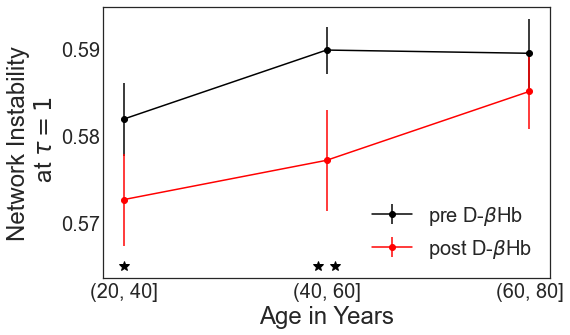

In [14]:
plt.figure(figsize=(8,5))
plt.errorbar(bolus_bhb1_avg.index,y=bolus_bhb1_avg["mean"],yerr=bolus_bhb1_avg["sem"],fmt="ok-",label=r"pre D-$\beta$Hb")
plt.errorbar(bolus_bhb2_avg.index,y=bolus_bhb2_avg["mean"],yerr=bolus_bhb2_avg["sem"],fmt="or-",label=r"post D-$\beta$Hb")
plt.ylabel("Network Instability\n at "r"$\tau=1$")
plt.xlabel("Age in Years")
plt.plot(0,0.565,"k*",markersize=10)
plt.plot(0.96,0.565,"k*",markersize=10)
plt.plot(1.04,0.565,"k*",markersize=10)
#plt.title("Critical Window for Intervention")
plt.legend()
#matplotlib.use('cairo')
plt.savefig("critical.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")
plt.savefig("critical.eps",format='eps',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [ ]:
np.sum(bolus_bhb1_avg['n'])

In [ ]:
bolus_bhb1_avg['n']

In [ ]:
bhb1_2040 = np.array(bolus_bhb1[bolus_bhb1["age_bin"]=="(20, 40]"]["instability"])
bhb2_2040 = np.array(bolus_bhb2[bolus_bhb2["age_bin"]=="(20, 40]"]["instability"])
ttest_rel(bhb1_2040,bhb2_2040)

In [ ]:
bhb1_4060 = np.array(bolus_bhb1[bolus_bhb1["age_bin"]=="(40, 60]"]["instability"])
bhb2_4060 = np.array(bolus_bhb2[bolus_bhb2["age_bin"]=="(40, 60]"]["instability"])
ttest_rel(bhb1_4060,bhb2_4060)

In [ ]:
bhb1_6080 = np.array(bolus_bhb1[bolus_bhb1["age_bin"]=="(60, 80]"]["instability"])
bhb2_6080 = np.array(bolus_bhb2[bolus_bhb2["age_bin"]=="(60, 80]"]["instability"])
ttest_rel(bhb1_6080,bhb2_6080)

In [ ]:
ttest_ind(bhb1_2040,bhb1_4060)

In [ ]:
mannwhitneyu(bhb1_2040,bhb1_4060)